In [1]:
# TTLS  A : (M X N1 X N2 X Q)   y:(M X 1)  x: (N1 x N2 X Q)
import tensorly as tl
import torch
import numpy as np
from utils import c_distance, create_error, make_CDP_operator,norm_estimate
import PIL.Image as Image
from ttls import spectralInit, ttls_solve




if __name__ == "__main__":
    np.random.seed(0)
    frame_num=3
    DTYPE=np.complex128
    # DTYPE=np.float64
    N_1 = 30
    N_2 = 10
    Q = frame_num
    N=N_1*N_2*Q
    L=4
    M=L*N
    # Number of measurements

    data=np.array(np.random.randint(0,256,size=[N_1, N_2,frame_num]), dtype=DTYPE)    
    data=np.array(np.random.normal(size=[N_1, N_2,frame_num]), dtype=DTYPE)*256
    data=np.zeros((10,30,frame_num),dtype=DTYPE)

    for i in range(frame_num):
        image_file='./data/'+str(i+1)+'.jpg'
        image = Image.open(image_file)
        image_data = np.array(image,dtype=DTYPE)
        data[:,:,i]=image_data
    
    
    
    a_SNR=30
    y_SNR=30

    # sampling_mode = 'Real'
    # sampling_mode = 'Complex'
    sampling_mode = 'CDP'
    
    np.random.seed(0)
    print ('N: ' + str(N) + ', M: ' + str(M) + ', a_SNR: ' + str(a_SNR) + ', y_SNR: ' + str(y_SNR))
    x=data.reshape(-1,1)
    
    # Create Real, Gaussian or CDP sensing vectors
    if sampling_mode == 'CDP':
        print ('Using coded diffraction measurement model')
        Am = make_CDP_operator(N, int(M / N), x.dtype, 'octanary')
        
    if sampling_mode == 'Real':
        print ('Using Real Gaussian measurement model') 
        Am = np.array(np.random.normal(size=[M, N]), dtype=np.float64)
        
    if sampling_mode == 'Complex':
        print ('Using Complex Gaussian measurement model') 
        Am = np.array(np.random.normal(size=[M, N]) + 1j*np.random.normal(size=[M, N]), dtype=np.complex128)

    # Create sensing vector errors
    E = np.array(np.random.normal(size=Am.shape) + 
                1j*np.random.normal(size=Am.shape), dtype=Am.dtype)
    
    # Obtain clean measurements
    xv=data.reshape(-1,1)
    y = np.abs(Am @ xv)**2

    # Create measurem
    # Create measurement errors
    e = np.random.normal(size=y.shape)
    
    # Scale sensing vector and measurement errors according to SNR
    Delta = create_error(Am, E, a_SNR)
    eta = create_error(y, e, y_SNR)
    
    # Perturb sensing vectors and measurements
    Am_measured = Am + Delta
    y_measured = y + eta

    A_measured = Am_measured.reshape([M,N_1,N_2,Q])
    print('Am_measured.shape',Am_measured.shape)
    print('y_measured.shape',y_measured.shape)
    # Original clean sensing vectors and measurements are no longer required
    del Am, y, E, e, Delta, eta
        
    norm__estimate = norm_estimate(y_measured)
    X0=spectralInit(y_measured, Am_measured, 2, [N_1,N_2,Q],50,N)
    X0 = X0 * norm__estimate
    print ('Initialization distance: ' + str(c_distance(xv, X0)/np.linalg.norm(xv)) + '\n')


    alpha = 1e11
    beta = 1
    lam_a = alpha*beta/N
    lam_y = alpha/ (norm__estimate**4)
    lam_m = 5e1
    ttls_lr = 2e6
    ttls_iter = 1000
    
    print ('N: ' + str(N) + ', M: ' + str(M) + ', a_SNR: ' + str(a_SNR) + ', y_SNR: ' + str(y_SNR)+' L:' + str(L))
    print ('alpha: ' + str(alpha) + ', beta: ' + str(beta) + ', lam_m: ' + str(lam_m) + ', step_size: ' + str(ttls_lr) )
    X_ttls, A_updated = ttls_solve(y_measured, A_measured, X0, ttls_lr, ttls_iter, norm__estimate, lam_a, lam_y,lam_m,xv,print_itear=False)
    xv_ttls=X_ttls.reshape(-1,1)
    ttls_dis=c_distance(xv, xv_ttls)/np.linalg.norm(xv)
    print ('TTLS distance:{}  \n'.format(ttls_dis))


N: 900, M: 3600, a_SNR: 30, y_SNR: 30
Using coded diffraction measurement model
Am_measured.shape (3600, 900)
y_measured.shape (3600, 1)
Initialization distance: 0.7872979938569828

N: 900, M: 3600, a_SNR: 30, y_SNR: 30 L:4
alpha: 100000000000.0, beta: 1, lam_m: 50.0, step_size: 2000000.0
TTLS iterations done:  1000
TTLS distance:0.0538417669100899  



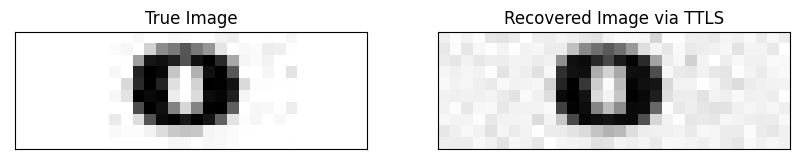

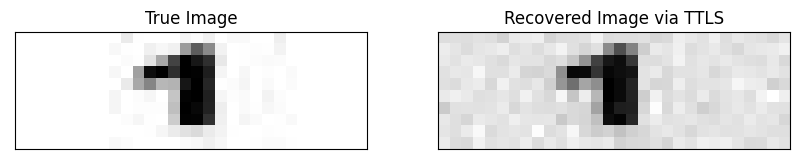

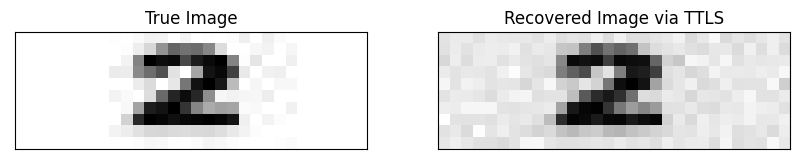

In [2]:
import matplotlib.pyplot as plt
plt.style.use('default')
# 假设 'data' 和 'X_ttls' 是你的3D数组，'frame_num' 是帧数
for i in range(frame_num):
    # 创建一个图和两个子图，1行2列
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # 在第一个子图上绘制True Image
    axs[0].imshow(np.abs(data[:,:,i]), cmap='gray')
    axs[0].set_title('True Image')
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    # 在第二个子图上绘制Recovered Image
    axs[1].imshow(np.abs(X_ttls[:,:,i].reshape([10,30])), cmap='gray')
    axs[1].set_title('Recovered Image via TTLS')
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    # 显示图像
    plt.show()
